Summary: verify travel times. Judge by comparing the error between grid and reported travel times. (assume I can use 3200 grid?)

In [3]:
import csv
import collections
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

## load all data

In [4]:
# This is the grid object, which is used throughout all data preprocessing.
# It represents the city of Austin through a series of grids.
# It thus makes a tractable way to compute distance between grids, ect. 
class Grid():
    def __init__(self, grid_json):
        self.grid = grid_json
        self.min_lat = self.grid["latitude_min"]
        self.min_lon = self.grid["longitude_min"]
        self.max_lat = self.grid["latitude_max"]
        self.max_lon = self.grid["longitude_max"]
        self.latitude_delta = self.grid["latitude_step"]
        self.longitude_delta = self.grid["longitude_step"]
        self.nrows = math.ceil((self.max_lat - self.min_lat) / self.latitude_delta)
        self.ncols = math.ceil((self.max_lon - self.min_lon) / self.longitude_delta)
        self.times = self.grid["time_matrix"]
        self.census_tract_region_map = self.grid["census_tract_region_mapping"]
        self.region_to_tract = collections.defaultdict(list)
        for census_tract in self.census_tract_region_map:
            for region in self.census_tract_region_map[census_tract]:
                self.region_to_tract[region].append(census_tract)
    def map_point_to_region(self, latitude, longitude):
        return math.floor((latitude-self.min_lat)/self.latitude_delta) * self.ncols  + math.floor((longitude-self.min_lon)/self.longitude_delta)
    def get_representative(self, region_num):
        row_num = region_num//self.ncols
        col_num = region_num - row_num*self.ncols
        lat = self.min_lat + row_num * self.latitude_delta + 0.5*self.latitude_delta
        lon = self.min_lon + col_num * self.longitude_delta + 0.5*self.longitude_delta
        return [lon, lat]
    def get_time(self, region1, region2):
        try:
            return self.times[region1][region2]
        except IndexError:
            return -1
    def region_to_census_tract(self, region):
        try:
            return self.region_to_tract[region]
        except KeyError:
            return "0_0"

In [5]:
peakHours = (np.genfromtxt("..\Output_Data/peakHours.csv", delimiter=",", dtype = str))

with open("..\Input_Data/grid_info_multiple.json", "r") as f:
    grid_json = json.load(f)
g = Grid(grid_json)

In [4]:
peakHours[0]

array(['', 'IncidentForeignKey', 'Radio_Name', 'Longitude_At_Assign_Time',
       'Latitude_At_Assign_Time', 'Time_Assigned', 'Time_Enroute',
       'Time_ArrivedAtScene', 'Time_Depart_Scene',
       'Time_Arrive_Destination', 'Time_Available', 'Time_Call_Cleared',
       'Call_Disposition', 'Longitude_Of_Emergency',
       'Latitude_Of_Emergency', 'transport_time', 'grid_time'],
      dtype='<U30')

## compare error with no adjustment
possibly adjust for dow, hour, number of grid tiles, specific path

In [5]:
print(peakHours[0,3]) #Longitude_At_Assign_Time
print(peakHours[0,4]) #Latitude_At_Assign_Time
print(peakHours[0,5]) #Time_Assigned
print(peakHours[0,6]) #Time_Enroute
print(peakHours[0,7]) #Time_ArrivedAtScene
print(peakHours[0,8]) #Time_Depart_Scene
print(peakHours[0,9]) #Time_Arrive_Destination
print(peakHours[0,10]) #Time_Available
print(peakHours[0,11]) #Time_Call_Cleared
print(peakHours[0,13]) #Longitude_Of_Emergency
print(peakHours[0,14]) #Latitude_Of_Emergency
print(peakHours[0,15]) #travel_time
print(peakHours[0,16]) #grid_time

Longitude_At_Assign_Time
Latitude_At_Assign_Time
Time_Assigned
Time_Enroute
Time_ArrivedAtScene
Time_Depart_Scene
Time_Arrive_Destination
Time_Available
Time_Call_Cleared
Longitude_Of_Emergency
Latitude_Of_Emergency
transport_time
grid_time


In [9]:
nsamples = 1000 #len(peakHours)
error_list = []
error_percent = []
for i in range(1,nsamples):
    start_pt = g.map_point_to_region(float(peakHours[i,4]),float(peakHours[i,3]))
    end_pt = g.map_point_to_region(float(peakHours[i,14]),float(peakHours[i,13]))
    grid_time = g.get_time(start_pt,end_pt)
    reported_time = float(peakHours[i,15])
#     if(reported_time -  grid_time < 2000):
#         print(str(start_pt) + " " + str(end_pt))
    error_list.append(reported_time -  grid_time)
    #error percent
    if(grid_time > reported_time):
        error_percent.append(grid_time/reported_time - 1)
    else: #grid_time <= reported_time
        error_percent.append(-1 * (1 - grid_time/reported_time))

2.062205423408877
1.8048832749599404
24.99134113626784
747.64


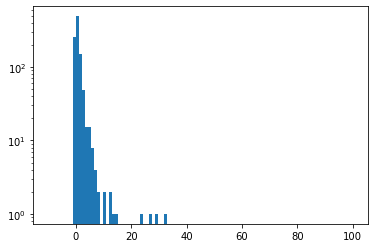

In [14]:
#plt.hist(error_list, bins = 100, log = True)
a = plt.hist(error_percent, bins = 100, range = (-10,100), log = True)
print(np.mean(np.abs(error_percent)))
print(np.mean(error_percent))
print(np.std(error_percent))
print(np.max(np.abs(error_percent)))

## Batches

In [39]:
#Summary: here we are comparing grid and reported travel time
#jupyter functions assume many variables are global like g (grid object) and peakHours (np array)
def nsample_verification(sample_start,nsamples):
    error_list = []
    error_percent = []
    for i in range(sample_start,sample_start + nsamples):
        start_pt = g.map_point_to_region(float(peakHours[i,4]),float(peakHours[i,3]))
        end_pt = g.map_point_to_region(float(peakHours[i,14]),float(peakHours[i,13]))
        grid_time = g.get_time(start_pt,end_pt)
        reported_time = float(peakHours[i,15])
    #     if(reported_time -  grid_time < 2000):
    #         print(str(start_pt) + " " + str(end_pt))
        error_list.append(reported_time -  grid_time)
        #error percent
        if(grid_time > reported_time):
            error_percent.append(grid_time/reported_time - 1)
        else: #grid_time <= reported_time
            error_percent.append(-1 * (1 - grid_time/reported_time))
#     print(np.mean(np.abs(error_percent)))
#     print(np.mean(error_percent))
#     print(np.std(error_percent))
#     print(np.max(np.abs(error_percent)))
    return (np.mean(np.abs(error_percent)), np.mean(error_percent),np.std(error_percent),np.max(np.abs(error_percent)),np.mean(error_list),np.std(error_list))

In [40]:
1.5673e-2

0.015673

In [41]:
#adjust by adding a global weight
W_GLOBAL = 1.5673e-2 #1.5673 percent -> ?seconds
def nsample_verification_global(sample_start,nsamples):
    error_list = []
    error_percent = []
    for i in range(sample_start,sample_start + nsamples):
        start_pt = g.map_point_to_region(float(peakHours[i,4]),float(peakHours[i,3]))
        end_pt = g.map_point_to_region(float(peakHours[i,14]),float(peakHours[i,13]))
        grid_time = g.get_time(start_pt,end_pt)
        grid_time = grid_time - 146
        reported_time = float(peakHours[i,15])
        error_list.append(reported_time -  grid_time)
        #error percent
        if(grid_time > reported_time):
            error_percent.append(grid_time/reported_time - 1)
        else: #grid_time <= reported_time
            error_percent.append(-1 * (1 - grid_time/reported_time))
    return (np.mean(np.abs(error_percent)), np.mean(error_percent),np.std(error_percent),np.max(np.abs(error_percent)),np.mean(error_list),np.std(error_list))

In [42]:
#adjust by adding seconds depending on time bin
time_bins = np.array([ 250, 550, 850, 1150, 1450, 1750])
time_bin_weights = np.array([201.70483660130716, 10.166325878594247, -208.83953125000002, -460.87083333333334, -775.0755555555556, -1046.168888888889, -1527.7117647058826]) 

def gridTime2Bin(grid_time):
    for i in range(time_bins.shape[0]):
        if(grid_time < time_bins[i]):
            return (i)
    return time_bins.shape[0]

def nsample_verification_times(sample_start,nsamples):
    error_list = []
    error_percent = []
    for i in range(sample_start,sample_start + nsamples):
        start_pt = g.map_point_to_region(float(peakHours[i,4]),float(peakHours[i,3]))
        end_pt = g.map_point_to_region(float(peakHours[i,14]),float(peakHours[i,13]))
        grid_time = g.get_time(start_pt,end_pt)
        grid_time = grid_time + time_bin_weights[gridTime2Bin(grid_time)]
        
        reported_time = float(peakHours[i,15])
        error_list.append(reported_time -  grid_time)
        #error percent
        if(grid_time > reported_time):
            error_percent.append(grid_time/reported_time - 1)
        else: #grid_time <= reported_time
            error_percent.append(-1 * (1 - grid_time/reported_time))
    return (np.mean(np.abs(error_percent)), np.mean(error_percent),np.std(error_percent),np.max(np.abs(error_percent)),np.mean(error_list),np.std(error_list))

In [53]:
np.random.seed(0)
sample_ind = []
mrp_mean_prcnt = []
mrp_std_prcnt = []
mrp_mean_secs = []
mrp_std_secs = []
for i in range(20):
    nsamples = 1000
    start = np.random.randint(low = 1, high = len(peakHours) - nsamples)
    batch_abs_mean, batch_mean, batch_std, batch_max, mean_seconds, std_seconds = nsample_verification_times(start,nsamples)
    mrp_mean_prcnt.append(batch_mean)
    mrp_std_prcnt.append(batch_std)
    mrp_mean_secs.append(mean_seconds)
    mrp_std_secs.append(std_seconds)
    sample_ind.append(start)

In [54]:
print(np.mean(mrp_mean))
print(np.std(mrp_mean))
print(np.mean(mrp_std))
print(np.std(mrp_std))
print(np.mean(mrp_mean_secs))
print(np.std(mrp_mean_secs))

1.1934591917767026
0.6706580210072545
13.150447573702943
8.661554791422438
-10.426597950259458
37.34551863813396


print(np.mean(mrp_mean))
print(np.std(mrp_mean))
print(np.mean(mrp_std))
print(np.std(mrp_std))
print(np.mean(mrp_mean_secs))
print(np.std(mrp_std_secs))

Original:
    1.1934591917767026
    0.6706580210072545
    13.150447573702943
    8.661554791422438
    -169.3827825
    43.433218727562995
Global:
    1.1934591917767026
    0.6706580210072545
    13.150447573702943
    8.661554791422438
    -23.382782499999998
    43.433218727562995
Bins:
    1.1934591917767026
    0.6706580210072545
    13.150447573702943
    8.661554791422438
    -10.426597950259458
    37.34551863813396


In [58]:
#MRP? https://uweb.engr.arizona.edu/~guzinb/webpage_before_June_30_2008/files/bm_compstat.pdf